### <center>MATHEMATICAL FOUNDATIONS OF COMPUTER GRAPHICS AND VISION</center>
##### <center>EXERCISE 2: GLOBAL OPTIMIZATION</center>
<center>Student: Akiyo Worou</center>

In [662]:
#Importing useful Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image, ImageDraw
from scipy.optimize import linprog

In [663]:
# Loading the data
data=loadmat('data/ListInputPoints.mat')['ListInputPoints']
leftImage=Image.open('data/InputLeftImage.png')
rightImage=Image.open('data/InputRightImage.png')

In [664]:
# Getting an idea of the dimensions
print(leftImage.size,len(data))
n=len(data)

(1104, 549) 55


In [665]:
# Plotting the initial image with all the data points
def concat_image(im1, im2,data):
    dst = Image.new('RGB', (im1.width + im2.width+10, min(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+10, 0))
    img = ImageDraw.Draw(dst)
    for i in range(len(data)):
        m=data[i]
        img.line([m[0],m[1],m[2]+im1.width+10,m[3]],fill="blue",width=3)
    return dst

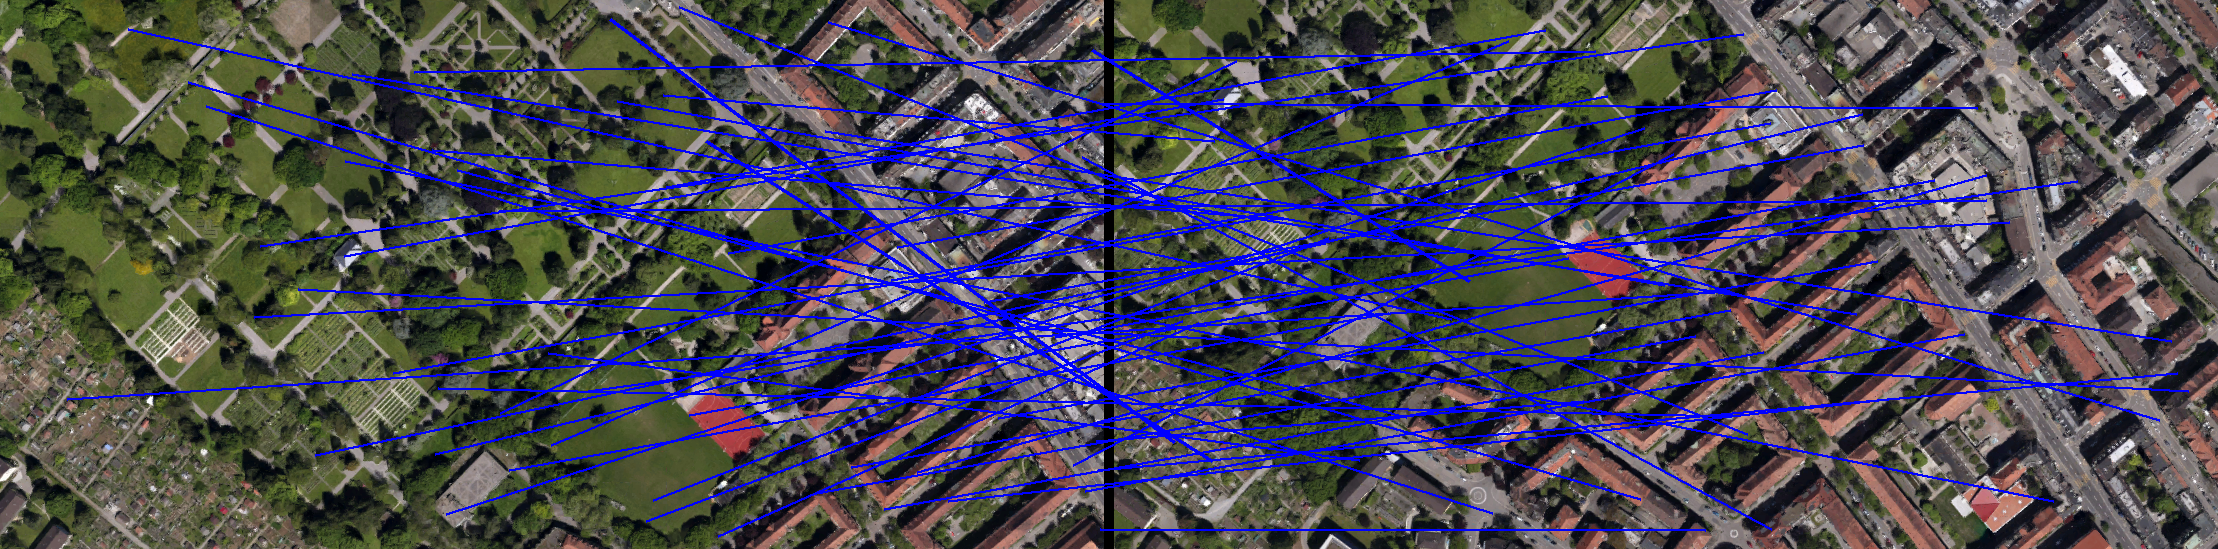

In [666]:
concat_image(leftImage,rightImage,data)

##### Reformulation

The problem that we need to to solve is the following: <br>
<center>$\underset{\Theta,S_I}{max}$  $card(S_I)$</center> 
$$ s.t. |x_i+T_x-x_i'| \leq \delta, \forall i \in S_I \subseteq S$$
$$ |y_i+T_y-y_i'| \leq \delta , \forall i \in S_I \subseteq S$$

By using the hints given we can rewrite the problem: <br>
$$\underset{\Theta,z,w}{max}\;\;\; \sum_{i=1}^nz_i$$
subject to
$$(x_i-x_i'-\delta)z_i+w_{ix} \leq 0$$
$$(x_i'-x_i-\delta)z_i-w_{ix} \leq 0$$
$$(y_i-y_i'-\delta)z_i+w_{iy} \leq 0$$
$$(y_i'-y_i-\delta)z_i-w_{iy} \leq 0$$

$$-T_x-\underline{T_x}z_i+w_{ix} \leq -\underline{T_x}$$
$$-\overline{T_x}z_i+w_{ix} \leq 0$$
$$\underline{T_x}z_i-w_{ix} \leq 0 $$
$$T_x+\overline{T_x}z_i-w_{ix} \leq \overline{T_x} $$

$$-T_y-\underline{T_y}z_i+w_{iy} \leq -\underline{T_y}$$
$$-\overline{T_y}z_i+w_{iy} \leq 0$$
$$\underline{T_y}z_i-w_{iy} \leq 0 $$
$$T_y+\overline{T_y}z_i-w_{iy} \leq \overline{T_y} $$

$$\underline{T_x} \leq T_x \leq \overline{T_x}$$
$$\underline{T_y} \leq T_y \leq \overline{T_y}$$
$$ 0 \leq z_i \leq 1$$
$$ -\infty \leq w_{ix} \leq \infty$$
$$ -\infty \leq w_{iy} \leq \infty$$
$$\forall i \in 1,....,n$$
Knowing that $w_{ix}=z_iT_x$ and  $w_{iy}=z_iT_y$,   $\forall i \in 1,....,n$ <br>

The representation given in (7) is used to solve the Linear Programming problem: $x=(T_x,T_y,z_1,...,z_n,w_{1x},...,w_{nx},w_{1y},...,w_{ny})$

In [667]:
delta=3

In [668]:
# Creating an Object thetaObj seems to be the best way to easily solve the problem
# The object takes for argument the theta boundaries,
#and use data and delta to compute the upper and lower bounds, the inliers list

In [669]:
class thetaObj:
    def __init__(self,lb,ub):
        self.ThetaLowerBound=lb
        self.ThetaUpperBound=ub
        
    # Getting the bounds 
    
    def ObjLowerBound(self,data,delta):
        return sum(self.ObjInliers(data,delta))
    
    def ObjUpperBound(self,data,delta):
        return -self.LinearProg(data,delta)[1]
    
    # defining objInliers as a list with 1 and 0
    # 1 if the couple is an inlier and 0 otherwise
    
    def ObjInliers(self,data,delta):
        theta_middle=self.ThetaOptimizer(data,delta)
        z=[]
        for i in range(n):
            if( abs(data[i,0]+theta_middle[0]-data[i,2])<=delta and abs(data[i,1]+theta_middle[1]-data[i,3])<=delta):
                z.append(1)
            else:
                z.append(0)
        return z
    
    
    # defining the optimal theta
    
    def ThetaOptimizer(self,data,delta):
        return self.LinearProg(data,delta)[0][:2]
    
    # Linear programing function 
    
    def LinearProg(self,data,delta):
        
        c=-np.array([0,0]+[1 for i in range (n)]+[0 for i in range(2*n)])
        A=[];b=[]
        for i in range(n):
            
            # Creating the matrix for the 12 inequalities
            Ai=[[0 for i in range(3*n+2)] for j in range(12)]
            
            #------------------------------------------------
            Ai[0][2+i]= data[i,0]-data[i,2]-delta
            Ai[0][2+n+i]=1

            Ai[1][2+i]= data[i,2]-data[i,0]-delta
            Ai[1][2+n+i]=-1

            Ai[2][2+i]= data[i,1]-data[i,3]-delta
            Ai[2][2+2*n+i]=1

            Ai[3][2+i]= data[i,3]-data[i,1]-delta
            Ai[3][2+2*n+i]=-1
            
            #------------------------------------------------
            Ai[4][0]=-1
            Ai[4][2+i]=-self.ThetaLowerBound[0]
            Ai[4][2+n+i]=1

            Ai[5][2+i]=-self.ThetaUpperBound[0]
            Ai[5][2+n+i]=1

            Ai[6][2+i]=self.ThetaLowerBound[0]
            Ai[6][2+n+i]=-1

            Ai[7][0]=1
            Ai[7][2+i]=self.ThetaUpperBound[0]
            Ai[7][2+n+i]=-1
            
            #------------------------------------------------
            Ai[8][1]=-1
            Ai[8][2+i]=-self.ThetaLowerBound[1]
            Ai[8][2+2*n+i]=1

            Ai[9][2+i]=-self.ThetaUpperBound[1]
            Ai[9][2+2*n+i]=1

            Ai[10][2+i]=self.ThetaLowerBound[1]
            Ai[10][2+2*n+i]=-1

            Ai[11][1]=1
            Ai[11][2+i]=self.ThetaUpperBound[1]
            Ai[11][2+2*n+i]=-1
            
            #------------------------------------------------
            bi=[0,0,0,0,
                    -self.ThetaLowerBound[0],0,0,self.ThetaUpperBound[0],
                    -self.ThetaLowerBound[1],0,0,self.ThetaUpperBound[1]]
            A+=Ai
            b+=bi
            
        # Getting the big matrix    
        A=np.array(A)
        b=np.array(b)
        
        # defining the boundaries
        lb=np.array(self.ThetaLowerBound+
                    [0 for i in range(n)]+
                    [None for j in range(n)]+
                    [None for j in range(n)] )
        ub=np.array( self.ThetaUpperBound+
                    [1 for i in range(n)]+
                    [None for j in range(n)]+
                    [None for j in range(n)] )
        bounds=[(lb[i],ub[i]) for i in range(len(lb))]
        
        # solving by using linprog
        result=linprog(c=c,A_ub=A,b_ub=b,bounds=bounds,method='revised simplex')
        return [result.x,result.fun]

In [670]:
# initialization
theta_start=thetaObj([-1104,-549],[1104,549])

In [671]:
# This code create two children Objtheta objects from a parent, 
#by dividing the space along the dimension with the longest length 

def theta_child(parent):
    x_mean=(parent.ThetaLowerBound[0]+parent.ThetaUpperBound[0])/2
    y_mean= (parent.ThetaLowerBound[1]+parent.ThetaUpperBound[1])/2
    if x_mean>=y_mean :
        return [thetaObj(parent.ThetaLowerBound,[x_mean,parent.ThetaUpperBound[1]]),
                thetaObj([x_mean,parent.ThetaLowerBound[1]],parent.ThetaUpperBound)]
    else:
        return [thetaObj(parent.ThetaLowerBound,[parent.ThetaUpperBound[0],y_mean]),
                thetaObj([parent.ThetaLowerBound[0],y_mean],parent.ThetaUpperBound) ]
        

In [672]:
# Here we perform the branch and bound algorithm

def branch_and_bound(theta_0):
    
    # initialization
    thetaSet=[theta_0]
    bestTheta=theta_0
    upperBound=[]
    lowerBound=[]

    while len(thetaSet) >0:
    
        
        # Get the last node
        theta=thetaSet.pop()
        upperBound.append(theta.ObjUpperBound(data,delta))
        lowerBound.append(theta.ObjLowerBound(data,delta))
        
        # get the child the highest Upper bound 
        children=theta_child(theta) 
        if children[0].ObjUpperBound(data,delta) >= children[1].ObjUpperBound(data,delta):
            child=children[0]
        else:
            child=children[1]
        
        # checking if the child improve the lowerBound
        if child.ObjLowerBound(data,delta) < bestTheta.ObjLowerBound(data,delta):
            children.remove(child)
            
        # getting the best child
        elif abs(child.ObjUpperBound(data,delta)-child.ObjLowerBound(data,delta))<=1:
            bestTheta=child
            upperBound.append(bestTheta.ObjUpperBound(data,delta))
            lowerBound.append(bestTheta.ObjLowerBound(data,delta))
            
        # adding a new node
        else:
            
            thetaSet.append(child)
        
    return bestTheta,upperBound,lowerBound
            
        
       

In [673]:
# Getting the optimal theta, the upperBound and the lowerBound

In [674]:
(bestTheta,upperBound,lowerBound)=branch_and_bound(theta_start)

C:\Users\Rudolf\Anaconda3\lib\site-packages\scipy\optimize\_linprog_rs.py:396: LinAlgWarning: Diagonal number 606 is exactly zero. Singular matrix.
  B.update(ab[i][l], j)       # modify basis


In [675]:
print("The optimal theta is given by: ",bestTheta.ThetaOptimizer(data,delta))
print("\n The inlier list is the following: \n",bestTheta.ObjInliers(data,delta))
print('\n The upper bound list: \n',upperBound)
print('\n The lower bound list: \n',lowerBound)

The optimal theta is given by:  [-232. -160.]

 The inlier list is the following: 
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

 The upper bound list: 
 [40.17940125197759, 28.15651527778089, 21.510215103704496, 19.298876747355912, 16.197399401661084, 15.380753138075312]

 The lower bound list: 
 [0, 0, 15, 15, 15, 15]


In [676]:
def plot_bounds(upperBound,lowerBound):
    # Negating the bounds to match the figure given
    NegUpperBound=[-int(x) for x in lowerBound]
    NegLowerBound=[-int(x) for x in upperBound]
    n=len(upperBound)
    X=[i+1 for i in range(n)]
    plt.plot(X,NegUpperBound,"-o",color='red',label='upper')
    plt.plot(X,NegLowerBound,"-o",color='blue',label='lower')
    plt.xlabel('iterations')
    plt.ylabel('Upper and lower bounds')
    plt.title('Convergence of bounds')
    plt.grid(True)
    plt.legend()
    plt.show()
    

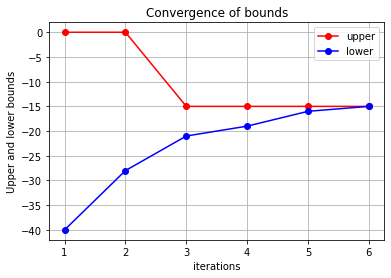

In [677]:
plot_bounds(upperBound,lowerBound)

In [678]:
# Getting the list of inliers
inliers_list=bestTheta.ObjInliers(data,delta)

In [689]:
# drawing the inliers and  on the image
def result_image(im1, im2,data,inliers_list):
    dst = Image.new('RGB', (im1.width + im2.width+10, min(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+10, 0))
    img = ImageDraw.Draw(dst)
    for i in range(len(data)):
        m=data[i]
        if inliers_list[i]==1:
            img.line([m[0],m[1],m[2]+im1.width+10,m[3]],fill="lime",width=3)
        else:
            img.line([m[0],m[1],m[2]+im1.width+10,m[3]],fill="red",width=3)
    return dst

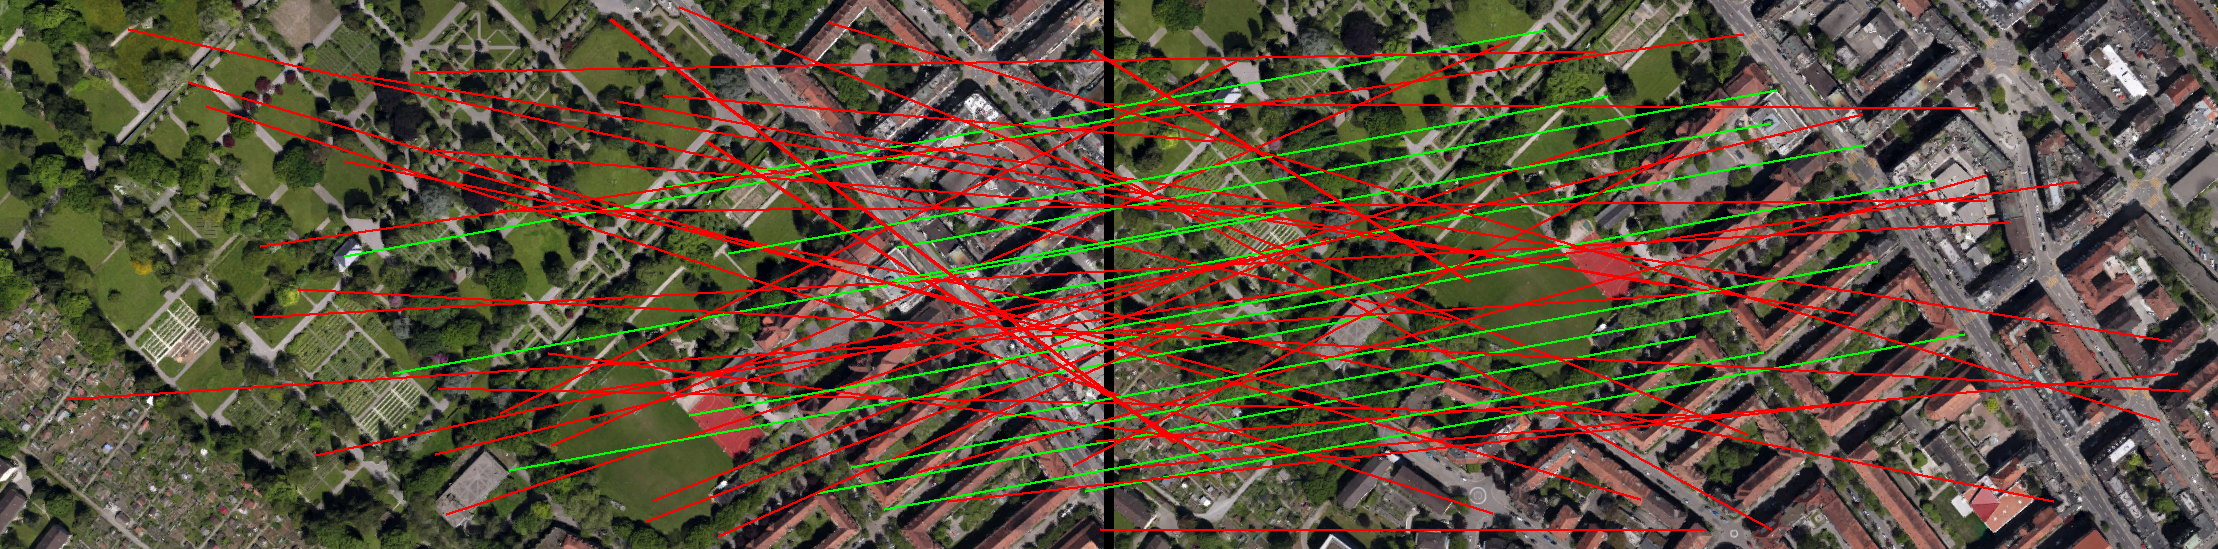

In [690]:
result_image(leftImage,rightImage,data,inliers_list)